In [37]:
from keras.models import load_model
import pandas as pd
import pickle
import tensorflow as tf
import numpy as np
import keras
import matplotlib.pyplot as plt

In [2]:
#Load model
model = load_model("../../models/TopoDNN/topodnnmodel/")
#Loading data
df_test = pd.read_pickle("../../datasets/topoprocessed/test.pkl")
sig = df_test.loc[df_test['is_signal_new'] == 1, df_test.columns != 'is_signal_new']
bkg = df_test.loc[df_test['is_signal_new'] == 0, df_test.columns != 'is_signal_new']
del df_test

2022-06-29 15:40:42.590087: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/rh/devtoolset-9/root/usr/lib64:/opt/rh/devtoolset-9/root/usr/lib:/opt/rh/devtoolset-9/root/usr/lib64/dyninst:/opt/rh/devtoolset-9/root/usr/lib/dyninst:/opt/rh/devtoolset-9/root/usr/lib64:/opt/rh/devtoolset-9/root/usr/lib
2022-06-29 15:40:42.590770: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-06-29 15:40:42.591540: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Dee

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               27300     
                                                                 
 activation (Activation)     (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 102)               30702     
                                                                 
 activation_1 (Activation)   (None, 102)               0         
                                                                 
 dense_2 (Dense)             (None, 12)                1236      
                                                                 
 activation_2 (Activation)   (None, 12)                0         
                                                                 
 dense_3 (Dense)             (None, 6)                 7

In [70]:
#Calculate LRP of signal jets
params = sig.columns
X = sig
L= len(model.layers)
layers = model.layers
A = [X]+[None]*L
A[0] = tf.convert_to_tensor(A[0])
print('Num_layers: ' + str(L))

Num_layers: 10


In [71]:
#Calculates model's steps
idx = 0
for layer in model.layers:
    #g=layer.get_config()['name']
    #act = layer.get_config()['activation']
    #h=layer.get_weights()
    A[idx+1]=layer(A[idx])
    idx+=1
print('done')

done


In [72]:
#Clones model
cloned_model = keras.models.clone_model(model)
cloned_model.set_weights(model.get_weights())
cloned_layers = cloned_model.layers

In [73]:
#Combine Dense+Activation functions
B = [A[0], A[2], A[4], A[6], A[8], A[10]]
# Backpropagate relevance scores
rho = lambda p: p;                       incr = lambda z: z+1e-9
R = [None]*5 + [B[-1]]
# Iterate over the layers in reverse order
for l in range(0,5)[::-1]:
    #if l <= 1:       rho = lambda p: p + 0.25*p.clamp(min=0); incr = lambda z: z+1e-9
    #if 2 <= l <= 3: rho = lambda p: p;                       incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5)
    #if l >= 4:       rho = lambda p: p;                       incr = lambda z: z+1e-9
    with tf.GradientTape() as tape:
        tape.watch(B[l])
        #Transform weights
        cloned_layers[2*l].set_weights([rho(cloned_layers[2*l].get_weights()[0]), rho(cloned_layers[2*l].get_weights()[1])])
        #Execute forward pass
        z = cloned_layers[2*l](B[l])
        z = incr(cloned_layers[2*l+1](z))
        # Element-wise division between relevance of the next layer and z
        s = (R[l+1]/z)
        
        s = tf.reshape(s, z.shape)
        # Calculate the gradient and multiply it by the activation
        c = tape.gradient(tf.reduce_sum(z*s.numpy()), B[l])
        # Assign new relevance values
        R[l] = (B[l]*c)

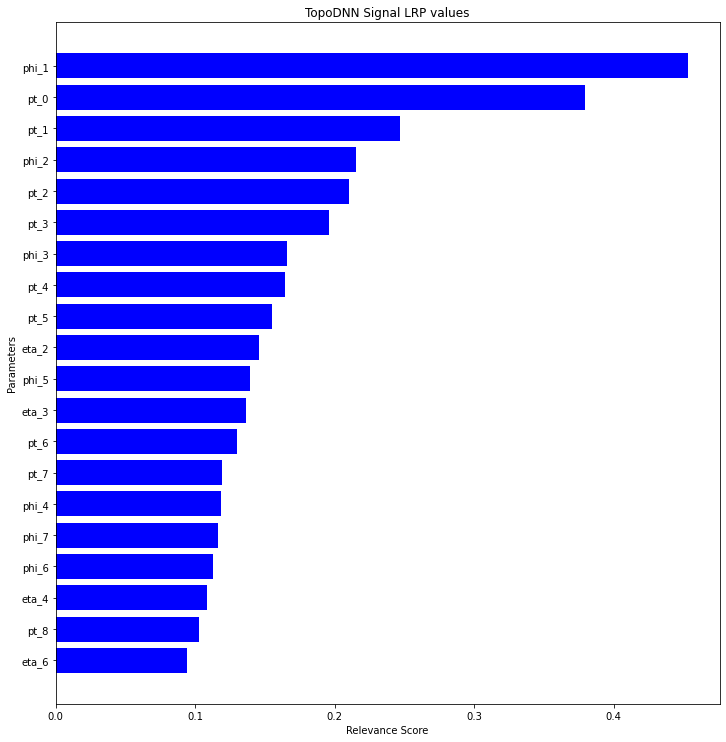

<Figure size 432x288 with 0 Axes>

In [74]:
#Plots relevances as normalized and take absolute value
normal_rel = np.empty_like(R[0])
#Normalizes relevances for each sample
normal_rel = R[0]/np.sum(R[0], 1)[:, np.newaxis]
relevances = np.nanmean(np.abs(normal_rel), 0) #Takes mean across all jets
df_sig_rel = pd.DataFrame(dict(params=params, rels=relevances))
df_sig_rel_sorted = df_sig_rel.sort_values('rels') #Sorts relevance values
fig = plt.figure(figsize = (10, 10))
# creating the bar plot
max_display = 20
plt.barh('params', 'rels', data = df_sig_rel_sorted.tail(max_display), color ='blue')
plt.tight_layout()
plt.xlabel("Relevance Score")
plt.ylabel("Parameters")
plt.title("TopoDNN Signal LRP values")
plt.show()
#Saves plot
# plt.savefig("figures/LRP_sig.png", dpi = 150, bbox_inches='tight')

In [75]:
#Calculate LRP of signal jets and steps
X = bkg
idx = 0
A = [X]+[None]*L
A[0] = tf.convert_to_tensor(A[0])

for layer in model.layers:
    #g=layer.get_config()['name']
    #act = layer.get_config()['activation']
    #h=layer.get_weights()
    A[idx+1]=layer(A[idx])
    idx+=1
print('done')

done


In [76]:
#Clones model
cloned_model = keras.models.clone_model(model)
cloned_model.set_weights(model.get_weights())
cloned_layers = cloned_model.layers

In [77]:
#Combine Dense+Activation functions
B = [A[0], A[2], A[4], A[6], A[8], A[10]]
# Backpropagate relevance scores
rho = lambda p: p;                       incr = lambda z: z+1e-9
R = [None]*5 + [B[-1]]
# Iterate over the layers in reverse order
for l in range(0,5)[::-1]:
    #if l <= 1:       rho = lambda p: p + 0.25*p.clamp(min=0); incr = lambda z: z+1e-9
    #if 2 <= l <= 3: rho = lambda p: p;                       incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5)
    #if l >= 4:       rho = lambda p: p;                       incr = lambda z: z+1e-9
    with tf.GradientTape() as tape:
        tape.watch(B[l])
        #Transform weights
        cloned_layers[2*l].set_weights([rho(cloned_layers[2*l].get_weights()[0]), rho(cloned_layers[2*l].get_weights()[1])])
        #Execute forward pass
        z = cloned_layers[2*l](B[l])
        z = incr(cloned_layers[2*l+1](z))
        # Element-wise division between relevance of the next layer and z
        s = (R[l+1]/z)
        
        s = tf.reshape(s, z.shape)
        # Calculate the gradient and multiply it by the activation
        c = tape.gradient(tf.reduce_sum(z*s.numpy()), B[l])
        # Assign new relevance values
        R[l] = (B[l]*c)

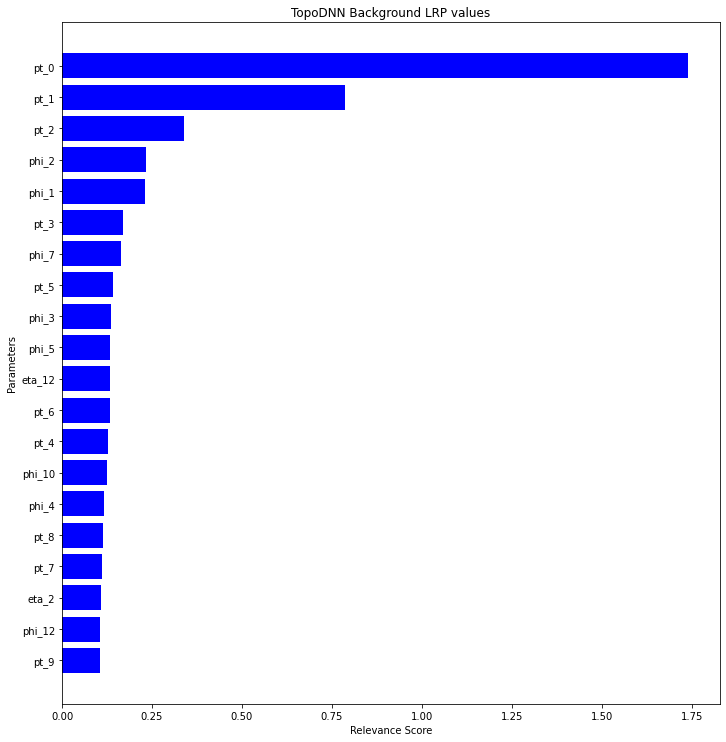

<Figure size 432x288 with 0 Axes>

In [78]:
#Plots relevances as normalized and take absolute value
normal_rel = np.empty_like(R[0])
#Normalizes relevances for each sample
normal_rel = R[0]/np.sum(R[0], 1)[:, np.newaxis]
relevances = np.nanmean(np.abs(normal_rel), 0) #Takes mean across all jets
df_bkg_rel = pd.DataFrame(dict(params=params, rels=relevances))
df_bkg_rel_sorted = df_bkg_rel.sort_values('rels')
fig = plt.figure(figsize = (10, 10))
# creating the bar plot
max_display = 20
plt.barh('params', 'rels', data = df_bkg_rel_sorted.tail(max_display), color ='blue')
plt.tight_layout()
plt.xlabel("Relevance Score")
plt.ylabel("Parameters")
plt.title("TopoDNN Background LRP values")
plt.show()
#Saves plot
plt.savefig("figures/LRP_bkg.png", dpi = 150, bbox_inches='tight')